In [ ]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tifffile
from scipy.spatial import distance_matrix
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

In [ ]:
slice_dir = Path('/lab/raw-data/EXP_JSM004_MN_DIV35')
mip_dir = Path('/lab/processed-data/EXP_JSM004_MN_DIV35/max_projections')
all_prefixes = [x.name[:13] for x in slice_dir.glob('*.tif')]
all_prefixes = np.sort(np.unique(all_prefixes))

In [ ]:
# Compile individual z-sections and save as MIPs
# was going to turn this into a function, but I don't think I'll be needing
# to do this in the future again.
channels = ['405', '488', '561', '647']

for prefix in all_prefixes:
    for ch in channels:

        z_section_files = [x.name for x in 
                           slice_dir.glob(prefix + '*' + ch +'*')]
        z_section_files = np.sort(z_section_files)

        img_stack = np.zeros((z_section_files.shape[0], 1024, 1024))
        img_stack = img_stack.astype('uint16')

        for i_f, f in enumerate(z_section_files):
            tif = skimage.io.imread(slice_dir / f)
            img_stack[i_f, :, :] = tif

        mip = img_stack.max(axis=0)
        skimage.io.imsave(mip_dir / (prefix + ch + '.tif'), mip)

In [ ]:
all_prefixes = [x.name[:13] for x in mip_dir.glob('*.tif')]
cellpose_mip_dir = mip_dir / 'cellpose'

# channels = ['405', '488', '561', '647']
channels = ['405', '561']

for prefix in all_prefixes:
    img_stack = np.zeros([len(channels), 1024, 1024])
    img_stack = img_stack.astype('uint16')
    for i_ch, ch in enumerate(channels):

        fname = prefix + ch +'.tif'

        tif = skimage.io.imread(mip_dir / fname)
        img_stack[i_ch, :, :] = tif

    tifffile.imwrite(cellpose_mip_dir / (prefix[:-1] + '.tif'), 
                    img_stack, metadata={'axes': 'CYX'}, 
                    imagej=True, compression=None, dtype='uint16')

In [ ]:
cellpose_mip_dir = mip_dir / 'cellpose' / 'nuclei'
seg_files = [x for x in cellpose_mip_dir.glob('*.npy')]
for fpath in seg_files:
    seg = np.load(fpath, allow_pickle=True)
    skimage.io.imsave(
        mip_dir / (fpath.name[:13] + 'hand_drawn_nuclei_masks.tif'), 
        seg.item()['masks']
    )

In [ ]:
data_dir = Path('/lab/processed-data/EXP_JSM004_MN_DIV35')
image_data = pd.read_csv(data_dir / 
                         '2023-02-01_jessie_tdp-43_MN_hand_drawn'/
                         '2023-01-09_tdp43_analysisImage.csv')
soma_data = pd.read_csv(data_dir / 
                        '2023-02-01_jessie_tdp-43_MN_hand_drawn'/
                        '2023-01-09_tdp43_analysiscytoplasm_outlines.csv')
nuclei_data = pd.read_csv(data_dir / 
                          '2023-02-01_jessie_tdp-43_MN_hand_drawn'/
                          '2023-01-09_tdp43_analysisnuclei.csv')


In [ ]:
# def get_ion(nucleus, soma):
#     """
#     Get intersection over nucleus. Similar to IoU, but divide by nucleus area
#     instead of union, because we want a metric for nucleus containment within
#     cytoplasm.
#     """

#     # coordinates of the area of intersection.
#     ix1 = np.maximum(nucleus[0], soma[0])
#     iy1 = np.maximum(nucleus[1], soma[1])
#     ix2 = np.minimum(nucleus[2], soma[2])
#     iy2 = np.minimum(nucleus[3], soma[3])
     
#     # Intersection height and width.
#     i_height = iy2 - iy1
#     i_width = ix2 - ix1
     
#     area_of_intersection = i_height * i_width
     
#     # Nucleus dimensions.
#     nucleus_height = nucleus[3] - nucleus[1]
#     nucleus_width = nucleus[2] - nucleus[0]

#     area_of_nucleus = nucleus_height * nucleus_width

#     # Soma dimensions.
#     soma_height = soma[3] - soma[1]
#     soma_width = soma[2] - soma[0]

#     area_of_soma = soma_height * soma_width
     
#     ion = area_of_intersection / (area_of_nucleus + area_of_soma - area_of_intersection)
#     # ion = area_of_intersection / (area_of_nucleus - area_of_intersection)
     
#     return ion

def get_ion(nucleus, soma, img_height = 1024, img_width = 1024):
    """
    Get intersection over nucleus. Similar to IoU, but divide by nucleus area
    instead of union, because we want a metric for nucleus containment within
    cytoplasm.
    """

    nucleus_img = np.zeros([img_height, img_width], dtype=bool)
    soma_img = np.zeros([img_height, img_width], dtype=bool)

    nucleus_img[nucleus[0]:nucleus[2], nucleus[1]:nucleus[3]] = True
    soma_img[soma[0]:soma[2], soma[1]:soma[3]] = True
    
    ion = (nucleus_img * soma_img).sum() / (nucleus_img).sum()
    return ion

def get_bounding_box(row):
    bb = [
        row['AreaShape_BoundingBoxMinimum_X'],
        row['AreaShape_BoundingBoxMinimum_Y'],
        row['AreaShape_BoundingBoxMaximum_X'],
        row['AreaShape_BoundingBoxMaximum_Y']
    ]
    return bb

In [ ]:
soma_reindex = []
for img_number in nuclei_data['ImageNumber'].unique():

    nd = nuclei_data.query('ImageNumber==@img_number')
    sd = soma_data.query('ImageNumber==@img_number')

    for i_nucleus, nd_row in nd.iterrows():
        nucleus_bb = get_bounding_box(nd_row)

        ion_list = []
        for i_soma, sd_row in sd.iterrows():
            soma_bb = get_bounding_box(sd_row)

            ion_list.append(get_ion(soma_bb, nucleus_bb))

        best_soma = np.array(ion_list).argmax()
        soma_reindex.append(sd.index[best_soma])

soma_data = soma_data.reindex(soma_reindex)
soma_data.index = np.arange(soma_data.shape[0])

In [ ]:
# data_dir = Path('/lab/processed-data/EXP_JSM002_NGN2_DIV25_wholeplate')
# image_data = pd.read_csv(data_dir / 
#                          '2022-12-12_tdp43_analysis'/
#                          '2022-12-12_tdp43_analysisImage.csv')
# soma_data = pd.read_csv(data_dir / 
#                         '2022-12-12_tdp43_analysis'/
#                         '2022-12-12_tdp43_analysiscytoplasm_outlines.csv')
# nuclei_data = pd.read_csv(data_dir / 
#                           '2022-12-12_tdp43_analysis'/
#                           '2022-12-12_tdp43_analysisnuclei.csv')

In [ ]:
measurement = 'Intensity_IntegratedIntensity_'
channels = ['TDP43_corrected', 'pTDP43_corrected']

ratio_data = pd.DataFrame(index = soma_data.index, 
                          columns = channels)
n_cells = soma_data.shape[0]
ratio_data['row'] = np.zeros(n_cells)
ratio_data['col'] = np.zeros(n_cells)
ratio_data['concentration'] = np.zeros(n_cells)
ratio_data['ImageNumber'] = soma_data['ImageNumber']

# Create ratio data
# for ch in channels:
    # ratio_data[ch] = ((soma_data[measurement + ch] - 
    #                    nuclei_data[measurement + ch]) / 
    #                   nuclei_data[measurement + ch])
    # ratio_data[ch].loc[ratio_data['ImageNumber'] == 1] = 1

# Add raw data columns to dataframe
ratio_data['TDP43_nucleus'] = nuclei_data[measurement + channels[0]] / nuclei_data['AreaShape_Area']
ratio_data['TDP43_cytoplasm'] = (soma_data[measurement + channels[0]] - 
                                 nuclei_data[measurement + channels[0]]) /  (soma_data['AreaShape_Area'] - nuclei_data['AreaShape_Area'])
ratio_data['pTDP43_nucleus'] = nuclei_data[measurement + 'p' + channels[0]]
ratio_data['pTDP43_cytoplasm'] = (soma_data[measurement + 'p' + channels[0]] - 
                                  nuclei_data[measurement + 'p' + channels[0]])
ratio_data['TDP43_ratio'] = (ratio_data['TDP43_cytoplasm'] / 
                             ratio_data['TDP43_nucleus'])
# Create lookup table for rows-concentrations
conc_lookup = {'A' : 'DMSO',
               'B' : '0.5 MG132',
               'C' : '0.5 MG132 + 8948',
               'D' : 'Cmpd. 8948'}

# Assign each cell a row & column index, and concentration (condition)
for i_cell in np.arange(n_cells):
    ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][7]
    ratio_data['col'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][8]
    ratio_data['concentration'].iloc[i_cell] = conc_lookup[ratio_data['row'].iloc[i_cell]]

# # Create lookup table for rows-concentrations
# conc_lookup = {'B' : 4e-6,
#                'C' : 2e-6,
#                'D' : 1e-6,
#                'E' : 500e-9,
#                'F' : 250e-9,
#                'G' : 125e-9}

# # Assign each cell a row & column index, and concentration (condition)
# for i_cell in np.arange(n_cells):
#     # ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][28]
#     # ratio_data['col'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][29:31]
#     ratio_data['row'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][25]
#     ratio_data['col'].iloc[i_cell] = soma_data['FileName_DAPI'].iloc[i_cell][26:28]
#     ratio_data['concentration'].iloc[i_cell] = conc_lookup[ratio_data['row'].iloc[i_cell]]

# # Remove first image, which is unlabeled
# ratio_data = ratio_data.drop(index=1)
# n_cells = ratio_data.shape[0]
# ratio_data.index = np.arange(n_cells)

n_cells = ratio_data.shape[0]
ratio_data.index = np.arange(n_cells)

Text(0.5, 0.98, 'Mutant 2')

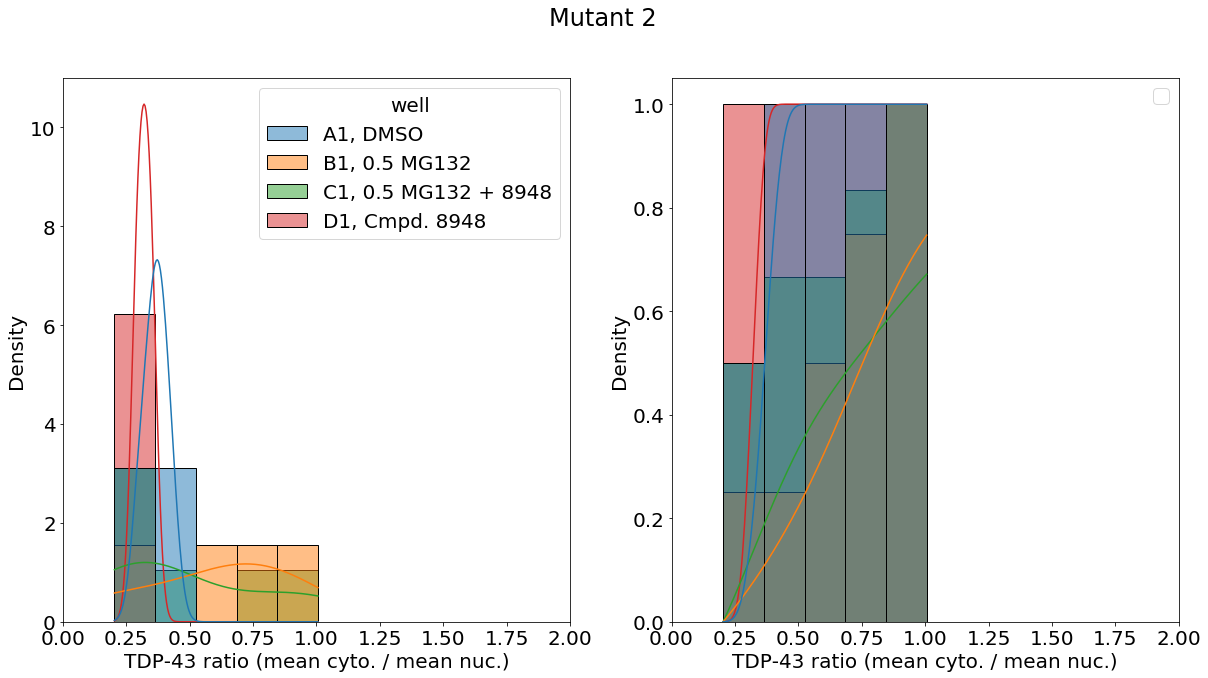

In [10]:
ratio_data.loc[ratio_data['col'] == '2', 'col'] = '1'
data = ratio_data.query('col=="1"')
# data = ratio_data.query('col==["02","06"]')
data = data.query('row==["A","B","C","D"]')
# data = data.query('row==["B","F"]')
data['well'] = data['row'] + data['col'] + ', ' + data['concentration']
# data['well'] = data['row'] + data['col'] 
fig, axs = plt.subplots(1,2)
# sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='col', kde=True, common_bins=True, stat='density', common_norm=False)
axs[0].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
sns.histplot(ax=axs[0], data=data, x='TDP43_ratio', hue='well', kde=True, common_bins=True, stat='density', common_norm=False)
axs[0].set_xlim([0, 2])
sns.histplot(ax=axs[1], data=data, x='TDP43_ratio', hue='well', kde=True, common_bins=True, stat='density', common_norm=False, cumulative=True)
axs[1].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
plt.legend([])
plt.xlim([0, 2])
plt.suptitle('Mutant 2')

Text(0.5, 0.98, 'Mutant 2')

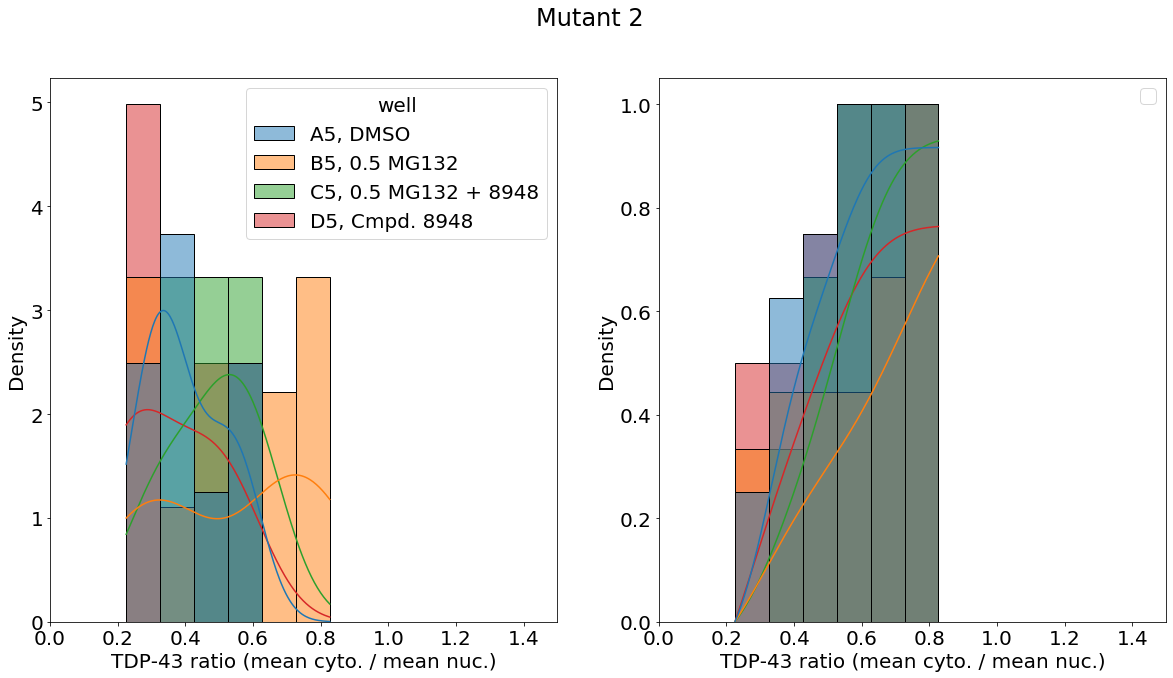

In [8]:
ratio_data.loc[ratio_data['col'] == '2', 'col'] = '1'
data = ratio_data.query('col=="5"')
data = data.query('row==["A","B","C","D"]')
data['well'] = data['row'] + data['col'] + ', ' + data['concentration']
fig, axs = plt.subplots(1,2)
# sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='col', kde=True, common_bins=True, stat='density', common_norm=False)
axs[0].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
sns.histplot(ax=axs[0], data=data, x='TDP43_ratio', hue='well', kde=True, common_bins=True, stat='density', common_norm=False)
axs[0].set_xlim([0, 1.5])
sns.histplot(ax=axs[1], data=data, x='TDP43_ratio', hue='well', kde=True, common_bins=True, stat='density', common_norm=False, cumulative=True)
axs[1].set_xlabel('TDP-43 ratio (mean cyto. / mean nuc.)')
plt.legend([])
plt.xlim([0, 1.5])
plt.suptitle('Mutant 2')

In [ ]:
ratio_data

In [ ]:
data

In [ ]:
img_number = 6
nuclei_centers = pd.concat((nuclei_data.query('ImageNumber==@img_number')['Location_Center_X'], nuclei_data.query('ImageNumber==@img_number')['Location_Center_Y']), axis=1)
soma_centers = pd.concat((soma_data.query('ImageNumber==@img_number')['Location_Center_X'], soma_data.query('ImageNumber==@img_number')['Location_Center_Y']), axis=1)

dm = distance_matrix(soma_centers, nuclei_centers)
sns.heatmap(dm)

In [ ]:
pd.DataFrame(dm)

In [ ]:
pd.DataFrame(nuclei_centers)

In [ ]:
soma_centers.shape

In [ ]:
soma_data.columns.tolist()

In [ ]:
nuclei_data.query('ImageNumber==6').loc[30, 'AreaShape_BoundingBoxMaximum_X']

In [ ]:
for img_number in range(1,13):
        # img_number = 6
    sxs = [soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_X'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_X'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_X'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_X'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_X']]

    sys = [soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_Y'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_Y'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_Y'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_Y'],
        soma_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_Y']]

    nxs = [nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_X'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_X'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_X'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_X'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_X']]

    nys = [nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_Y'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_Y'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMaximum_Y'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_Y'],
        nuclei_data.query('ImageNumber==@img_number')['AreaShape_BoundingBoxMinimum_Y']]

    plt.plot(nuclei_data.query('ImageNumber==@img_number')['Location_Center_X'],
            nuclei_data.query('ImageNumber==@img_number')['Location_Center_Y'], 'r*')
    plt.plot(soma_data.query('ImageNumber==@img_number')['Location_Center_X'],
            soma_data.query('ImageNumber==@img_number')['Location_Center_Y'], 'k*')
    plt.plot(sxs, sys, 'k')
    plt.plot(nxs, nys, 'r')
    plt.ylim([0, 1024])
    plt.xlim([0, 1024])
    plt.gca().invert_yaxis()
    plt.title(img_number)
    plt.show()

In [ ]:
d

In [ ]:
data['col']

In [ ]:
ratio_data.loc[ratio_data['col'] == '2', 'col'] = '1'
# data = ratio_data.query('col==["02","06"]')
data = ratio_data.query('col=="1"')
data = data.query('row==["A","B"]')
data['well'] = data['row'] + data['col']
data = data.drop(data.index[data['ImageNumber']==1]).drop(data.index[data['ImageNumber']==51])
fig, axs = plt.subplots(1,2)
# sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='col', kde=True, common_bins=True, stat='density', common_norm=False)
sns.histplot(ax=axs[0], data=data, x='TDP43_corrected', hue='well', kde=True, common_bins=True, stat='density', common_norm=False)
axs[0].set_xlim([0, 2])
sns.histplot(ax=axs[1], data=data, x='TDP43_corrected', hue='well', kde=True, common_bins=True, stat='density', common_norm=False, cumulative=True)
plt.xlim([0, 2])
# plt.suptitle('Cols 2 & 7, pooled within col')
plt.suptitle('All wells (independently) in cols 2 & 7')

In [ ]:
data_dir = Path('/lab/processed-data/EXP_JSM004_MN_DIV35')
# pm = pd.read_csv('/lab/processed-data/EXP_JSM002_NGN2_DIV25_wholeplate/platemap.csv')
pm = pd.read_csv(data_dir / '2023-02-01_jessie_tdp-43_MN_hand_drawn'/'2023-01-09_tdp43_analysisImage.csv')
pm['filename'] = pm['FileName_DAPI']
# img_dir = 'max_projections'
img_dir = '2023-02-01_jessie_tdp-43_MN_hand_drawn/nuclei_outlines'

In [ ]:
img_stack = np.zeros((pm.shape[0], 1024, 1024))
img_stack = img_stack.astype('uint16')
for i_file, file in enumerate(pm['filename']):
    tif = skimage.io.imread(data_dir / img_dir / (file + 'f'))
    # tif = skimage.io.imread(data_dir / img_dir / (file))
    img_stack[i_file, :, :] = tif
# img_stack 
tifffile.imwrite(data_dir / ('2023-02-01_jessie_tdp-43_MN_hand_drawn_nuclei_outlines.tiff'), img_stack, metadata={'axes': 'ZYX'}, imagej=True, compression='lzw', dtype='uint16')
# tifffile.imwrite(data_dir / ('max_projections.tiff'), img_stack, metadata={'axes': 'ZYX'}, imagej=True, compression='lzw', dtype='uint16')